In [41]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [31]:
dataset_path = "final_data"

train_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "training",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)


validation_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "validation",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)

Found 1895 files belonging to 16 classes.
Using 1516 files for training.
Found 1895 files belonging to 16 classes.
Using 379 files for validation.


In [ ]:

model = models.Sequential([
    
    layers.Conv1D(64, kernel_size=80, strides=16, activation="relu", input_shape=(48000, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    
    
    layers.Conv1D(128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    

    layers.Conv1D(256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.3),  

  
    layers.Conv1D(512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.4),  

    
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dropout(0.5),  
    layers.Dense(16, activation="softmax")  
])


In [ ]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [34]:

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=5,          
    restore_best_weights=True  
)


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   
    factor=0.5,          
    patience=3,          
    min_lr=1e-6           
)


history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    callbacks=[early_stopping, reduce_lr] 
)

model.save("final_model.keras")

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 207s 524ms/step - accuracy: 0.2384 - loss: 4.4342 - val_accuracy: 0.0528 - val_loss: 6.9875 - learning_rate: 0.0010
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 196s 517ms/step - accuracy: 0.4502 - loss: 2.8284 - val_accuracy: 0.7678 - val_loss: 1.5275 - learning_rate: 0.0010
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 196s 516ms/step - accuracy: 0.5340 - loss: 2.1238 - val_accuracy: 0.7836 - val_loss: 1.2405 - learning_rate: 0.0010
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 204s 538ms/step - accuracy: 0.6181 - loss: 1.7362 - val_accuracy: 0.8417 - val_loss: 0.9370 - learning_rate: 0.0010
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 201s 530ms/step - accuracy: 0.6344 - loss: 1.5938 - val_accuracy: 0.8417 - val_loss: 0.8429 - learning_rate: 0.0010
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 200s 528ms/step - accuracy: 0.6942 - loss: 1.3559 - val_accuracy: 0.8945 - val_loss: 0.7318 - learning_rate: 0.0010
Epoch 7/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 3239s 9s/step - accuracy

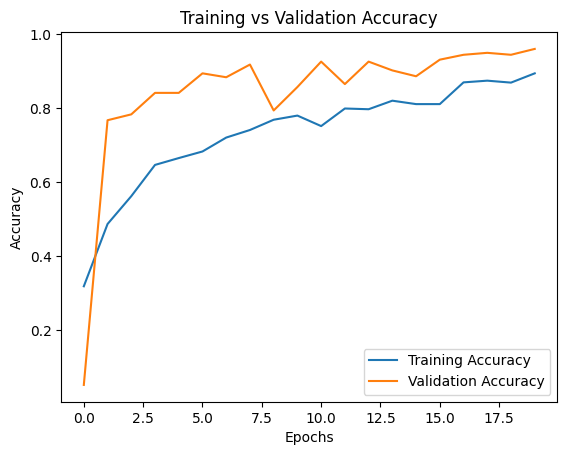

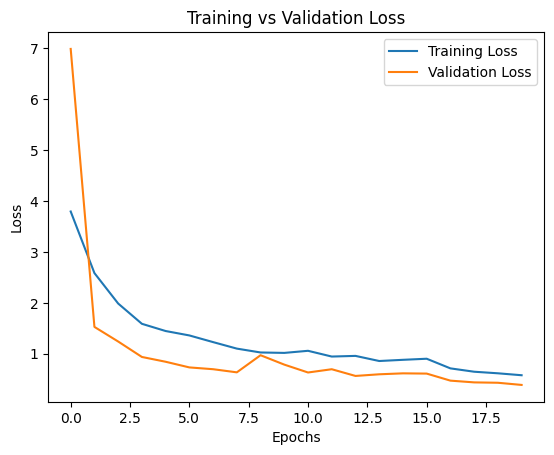

In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

final_metrics = {
    "Epoch": len(train_accuracy),
    "Train Accuracy": train_accuracy[-1],
    "Validation Accuracy": val_accuracy[-1],
    "Train Loss": train_loss[-1],
    "Validation Loss": val_loss[-1]
}

final_metrics_df = pd.DataFrame([final_metrics])


print("\nFinal Training and Validation Metrics:\n")
print(final_metrics_df.to_string(index=False))



Final Training and Validation Metrics:

 Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
    20        0.894459             0.960422     0.57816         0.387887


In [44]:
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in validation_data], axis=0)
true_labels = np.argmax(true_labels, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


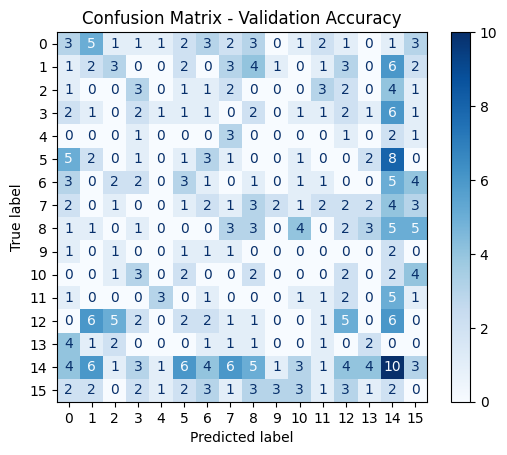

In [45]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Accuracy')
plt.show()

In [ ]:
def predict_audio(audio_path):
    audio, sr = tf.audio.decode_wav(tf.io.read_file(audio_path))
    audio = tf.expand_dims(audio, axis=0)
    audio = tf.keras.preprocessing.sequence.pad_sequences(audio, maxlen=48000, padding="post", truncating="post")
    predictions = model.predict(audio)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class


audio_path = ""
predicted_class = predict_audio(audio_path)
print(f"Predicted class: {predicted_class}")